This script implements the EN-S regularization algorithm. 

Aghazadeh A, Nisonoff H, Ocal O, Brookes DH, Huang Y, Koyluoglu OO, Listgarten J, Ramchandran K. Sparse epistatic regularization of deep neural networks for inferring fitness functions. bioRxiv. 2021 Jan 1:2020-11. doi: https://doi.org/10.1101/2020.11.24.396994


In [1]:
import numpy as np
import pandas as pd
from itertools import product
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib.pyplot as plt

import seaborn as sns
from utils import *

sns.set_style('white')
sns.set_context('talk')

In [2]:
def walsh_hadamard_matrix(L=13, normalize=False):
    '''
    Compute the WHT matrix for domain of dimension L
    '''
    H1 = np.asarray([[1.,1.], [1.,-1.]])
    H = np.asarray([1.])
    for i in range(L):
        H = np.kron(H, H1)
    if normalize:
        H = (1 / np.sqrt(2**L)) * H
    return H

In [3]:
data = pd.read_excel(open('41467_2019_12130_MOESM7_ESM.xlsx', 'rb')) 
data.head()

,binary,amino acid,counts,counts.1,counts.2,Unnamed: 5,brightness,brightness.1,Unnamed: 8,brightness.2
0,genotype,sequence,input,red,blue,NaN,red,blue,NaN,combined
1,'0000000000000',DVLTFNSAAYNNK,5431,12,7846,NaN,0.085317,1.574628,NaN,1.574635
2,'0000000000001',DVLTFNSAAYNNR,6574,11,9047,NaN,0.075637,1.544269,NaN,1.544276
3,'0000000000010',DVLTFNSAAYNKK,10493,33,13352,NaN,0.103633,1.49045,NaN,1.490458
4,'0000000000011',DVLTFNSAAYNKR,9545,35,12513,NaN,0.106846,1.511977,NaN,1.511984


In [4]:
# get genotypes as strings. the excell file has some odd formating
# so we remove the first row and get rid of extra quotes at beginning
# and end
genotypes = data['binary'].to_numpy()[1:]
genotypes = [x[1:-1] for x in genotypes]
brightness = data['brightness.2'][1:].to_numpy(dtype=np.float)

genotype_to_brightness = {g:b for g,b in zip(genotypes, brightness)}

# get dimension of input
L = len(genotypes[0])
# size of the landscape
N = 2**L

/var/folders/0m/znv2x4f15l370c2fvtf4t8kh0000gn/T/ipykernel_75286/1444983188.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  brightness = data['brightness.2'][1:].to_numpy(dtype=np.float)


In [5]:
# get all 2^L inputs
all_inputs = np.asarray(list((product((0,1), repeat=L))))
# convert to strings
all_inputs_as_str = [''.join(map(str, x)) for x in all_inputs]
# get y-values for all possible x-values
landscape = np.asarray([genotype_to_brightness[g] for g in all_inputs_as_str])

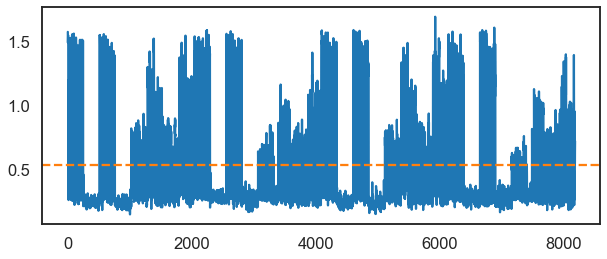

In [6]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(landscape)
ax.axhline(np.mean(landscape), color='C1', linestyle='--')

In [7]:
# create WHT matrix 
H = walsh_hadamard_matrix(L=L)
# get WH coefficients
spectrum = np.dot(H, landscape)

Text(0.5, 1.0, 'WHT')

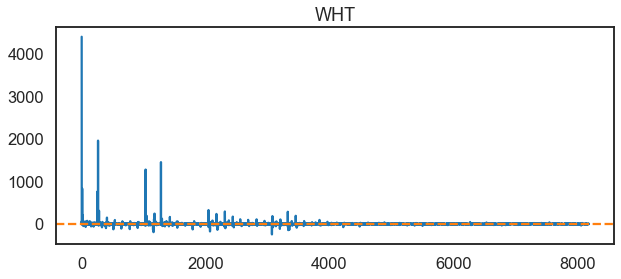

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(spectrum)
ax.axhline(np.mean(spectrum), color='C1', linestyle='--')
ax.set_title('WHT')

In [9]:
spectrum_sorted = np.sort(np.abs(spectrum))[::-1]
# get normalized cumulative energy
cumulative_energy = np.zeros(N)
total_energy = np.linalg.norm(spectrum_sorted)
for ind in range(N):
    cumulative_energy[ind] = np.linalg.norm(spectrum_sorted[0:ind]) / total_energy

Text(0.5, 1.0, 'Cumulative Energy (Top 100 Coefficients)')

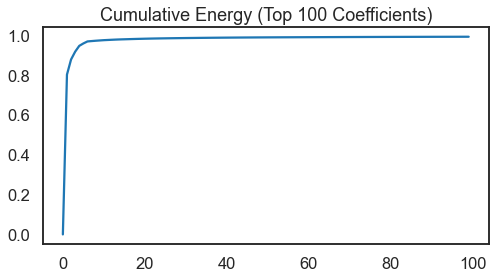

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
top_k = 100
ax.plot(cumulative_energy[0:top_k])
ax.set_title(f'Cumulative Energy (Top {top_k} Coefficients)')

Now let's train a network using EN-regularization

In [11]:
class Net(nn.Module):
    def __init__(self, n, multiplier):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.bn1 = nn.BatchNorm1d(multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.bn2 = nn.BatchNorm1d(multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.bn3 = nn.BatchNorm1d(n)
        self.fc4 = nn.Linear(n, 1)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = self.bn1(F.leaky_relu(self.fc1(x)))
        x = self.bn2(F.leaky_relu(self.fc2(x)))
        x = self.bn3(F.leaky_relu(self.fc3(x)))
        x = self.fc4(x)
        return x.reshape(-1)


In [12]:
def compute_wht_spectrum(model, H, all_inputs, device="cuda"):
    '''
    Compute the WH spectrum of the DNN model
    Used for EN-regularization
    '''
    all_inputs = all_inputs.to(device)
    H = H.to(device)
    # get all outputs of model (aka landscape)
    landscape = model(all_inputs).reshape(-1)
    # compute spectrum by matrix-vector multiplication with WHT basis
    spectrum = torch.matmul(H, landscape)
    # clear up gpu memory
    H.to("cpu")
    all_inputs.to("cpu")
    return spectrum

In [13]:
def train_model(model, train_dl, val_dl, H, all_inputs, lr=1e-3, weight_decay=0.0, reg_lambda=1e-2, rho=0.01, num_epochs=20, device="cuda"):
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    l2_loss = torch.nn.MSELoss()
    
    # these are the uniform sampling protein pattern
    # parameters are set as N=13 mutations, m=4 anticipated sparsity level, and d=3 number of offsets
    sampling_matrix1  = pickle.load(open('N13-m4-d3/sampling-matrix-1.p','rb'))
    sampling_matrix2  = pickle.load(open('N13-m4-d3/sampling-matrix-2.p','rb'))
    sampling_matrix3  = pickle.load(open('N13-m4-d3/sampling-matrix-3.p','rb'))
    delays_matrix1 = pickle.load(open('N13-m4-d3/delays-1.p','rb'))
    delays_matrix2 = pickle.load(open('N13-m4-d3/delays-2.p','rb'))
    delays_matrix3 = pickle.load(open('N13-m4-d3/delays-3.p','rb'))
    all_sampling_locations1 = pickle.load(open('N13-m4-d3/sampling-locations-1.p','rb'))
    all_sampling_locations2 = pickle.load(open('N13-m4-d3/sampling-locations-2.p','rb'))
    all_sampling_locations3 = pickle.load(open('N13-m4-d3/sampling-locations-3.p','rb'))
    
    X_all = np.concatenate((np.vstack(all_sampling_locations1),np.vstack(all_sampling_locations2),np.vstack(all_sampling_locations3)))
    X_all,X_all_inverse_ind = np.unique(X_all, axis=0, return_inverse='True')
    
    # initialzie ADMM 
    Hu = np.zeros(len(X_all))
    lam = np.zeros(len(X_all))
    
    for epoch in range(num_epochs):
        ###############################
        ########## TRAIN LOOP #########
        ###############################
        model.train()
        for X, y in train_dl:
            optim.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = F.mse_loss(y, y_hat)

            # Apply EN-S regularization
            #spectrum = compute_wht_spectrum(model, H, all_inputs, device=device)
            #reg_loss = F.l1_loss(spectrum, torch.zeros_like(spectrum))
            #loss += reg_lambda * reg_loss
            
            #spectrum2 = compute_wht_spectrum(model, H, torch.tensor(X_all, dtype=torch.float), device=device)
            wht_out = model(torch.tensor(X_all, dtype=torch.float)).reshape(-1)
            wht_diff = wht_out - torch.tensor(Hu, dtype=torch.float) + torch.tensor(lam, dtype=torch.float)
            reg_loss = rho/2 * l2_loss(wht_diff,torch.zeros_like(wht_diff))
            loss += reg_lambda * reg_loss

            loss.backward()
            optim.step()
        
        with torch.no_grad():
            y_hat_all = model(torch.from_numpy(X_all).float())
        y_hat_all = y_hat_all.numpy().flatten()
    
    
        # run spright to do fast sparse WHT
        spright = SPRIGHT('frame', [1,2,3],sampling_matrix1,sampling_matrix2,sampling_matrix3,delays_matrix1,delays_matrix2,delays_matrix3,all_sampling_locations1,all_sampling_locations2,all_sampling_locations3)
        spright.set_train_data(X_all,  y_hat_all + lam, X_all_inverse_ind)
        spright.model_to_remove = model
        flag = spright.initial_run()
        if not flag:
            continue
        spright.peel_rest()
        
        M = make_system_simple(np.vstack(spright.model.support), X_all)
        Hu = np.dot(M,spright.model.coef_)
        
        # update the dual 
        lam = lam + y_hat_all - Hu

        ###############################
        ########## VAL LOOP #########
        ###############################
        model.eval()
        with torch.no_grad():
            X, y = next(iter(val_dl))
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            val_loss = F.mse_loss(y, y_hat).item()
            print(f"Validation Loss: {val_loss:.3f}")
    return model

In [14]:
################################################
######## Get WHT Matrix and All Inputs #########
################################################

H = walsh_hadamard_matrix(L=L)
all_inputs = np.asarray(list((product((0,1), repeat=L))))
H = torch.tensor(H, dtype=torch.float)
all_inputs = torch.tensor(all_inputs, dtype=torch.float)


In [15]:
################################################
###### Get Dataset and Split Train/Test ########
################################################

torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

n_train = 60
bs = 16

X_all = torch.tensor([[float(x) for x in g] for g in genotypes], dtype=torch.float)
y_all = torch.tensor(brightness, dtype=torch.float)
n = X_all.shape[0]
ds = TensorDataset(X_all,y_all)

# Create Datasets / DataLoaders
train_ds, val_ds, test_ds = random_split(ds, lengths=[n_train, n_train, n - 2*n_train])
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)


In [16]:
lr = 1e-3
weight_decay = 0.0
reg_lambda = 1e-2  ## with EN regularization
num_epochs = 20
rho = 0.01
device = "cpu"

torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

model = Net(L, 2)
model = train_model(model, train_dl, val_dl, H, all_inputs, 
                    lr=lr, weight_decay=weight_decay, reg_lambda=reg_lambda, rho=rho, 
                    num_epochs=num_epochs, device=device)


model.eval()
with torch.no_grad():
    X, y = next(iter(test_dl))
    X, y = X.to(device), y.to(device)
    y_hat = model(X)
    test_loss = F.mse_loss(y_hat, y).item()
    print(f"Test Loss: {test_loss:.3f}")

Validation Loss: 0.263
Validation Loss: 0.320
Validation Loss: 0.486
Validation Loss: 0.691
Validation Loss: 0.881
Validation Loss: 1.018
Validation Loss: 1.056
Validation Loss: 1.061
Validation Loss: 0.910
Validation Loss: 0.788
Validation Loss: 0.751
Test Loss: 0.653


In [17]:
lr = 1e-3
weight_decay = 0.0
reg_lambda = 0     ## without EN regularization
num_epochs = 20
device = "cpu"
model = Net(L, 2)
model = train_model(model, train_dl, val_dl, H, all_inputs, 
                    lr=lr, weight_decay=weight_decay, reg_lambda=reg_lambda, 
                    num_epochs=num_epochs, device=device)


model.eval()
with torch.no_grad():
    X, y = next(iter(test_dl))
    X, y = X.to(device), y.to(device)
    y_hat = model(X)
    test_loss = F.mse_loss(y_hat, y).item()
    print(f"Test Loss: {test_loss:.3f}")

Validation Loss: 1.248
Validation Loss: 2.106
Validation Loss: 2.118
Validation Loss: 2.028
Validation Loss: 1.830
Validation Loss: 1.336
Validation Loss: 1.295
Validation Loss: 1.293
Validation Loss: 1.265
Validation Loss: 1.254
Test Loss: 1.091
